# Finding Motion vectors

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from image_comression import *
from run_length import *

In [2]:
def sum_of_absolute_difference(image1,image2):
    diff = np.abs(image1 - image2)
    sad = np.sum(diff)
    return sad

# Searching for a simmilar block

Sequential search

In [3]:
def sequential_search(block,frame_100):
    block_height, block_width = block.shape  # Get block dimensions
    frame2_height,frame2_width = frame_100.shape
    min_sad = np.inf  # Initialize minimum SAD
    best_match_x = 0
    best_match_y = 0
    itter_2 = 0
    for y in range(0, frame2_height - block_height):
        for x in range(0, frame2_width - block_width):
            itter_2 = itter_2 + 1
            candidate_block = frame_100[y:y+block_height, x:x+block_width]

            # Calculate SAD between the block and candidate block
            sad = np.sum(np.abs(block - candidate_block))

            # Update best match if SAD is lower
            if sad < min_sad:
                min_sad = sad
                best_match_x = x
                best_match_y = y

    return best_match_x,best_match_y

logarithmic search (Much faster but not that acurate)

In [4]:
import numpy as np

def logarithmic_search_2d(frame, block,curent_x,current_y):
    block_height, block_width = block.shape
    frame2_height, frame2_width = frame.shape

    if block_height > frame2_height or block_width > frame2_width:
        raise ValueError("Block dimensions exceed frame dimensions.")

    search_range = max(frame2_height, frame2_width) // 2
    best_match_x, best_match_y = curent_x,current_y
    min_sad = np.inf
    itter = 0
    while search_range >= 1:
        # Generate nine candidate positions in the current search window
        candidates = [(best_match_x + i * search_range, best_match_y + j * search_range)
                      for i in [-1, 0, 1] for j in [-1, 0, 1]]

        # Filter out candidates that exceed frame boundaries
        candidates = [(x, y) for x, y in candidates
                      if 0 <= x < frame2_width - block_width + 1 and 0 <= y < frame2_height - block_height + 1]

        for x, y in candidates:
            itter = itter + 1
            candidate_block = frame[y:y + block_height, x:x + block_width]
            sad = np.sum(np.abs(block - candidate_block))

            if sad < min_sad:
                min_sad = sad
                best_match_x, best_match_y = x, y

        # Update search range for the next iteration (reduce by half)
        search_range //= 2

    return best_match_x, best_match_y, min_sad,itter


# Loading 10 frames

In [5]:
frames = np.empty((0, 640, 640))

for i in range(70,180,10):
    frame = cv2.resize(cv2.imread(f"test_frames_2/frame_{i}.png",0), (640, 640))
    frames = np.concatenate((frames, [frame]), axis=0)
print(frames.shape)

(11, 640, 640)


In [6]:
def display_images(frames):
    num_rows, num_cols = 2, 5
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))
    axes = axes.flatten()

    # Loop through the images and display them in subplots with titles
    for i in range(num_rows * num_cols):
        if i < len(frames):
            axes[i].imshow(frames[i], cmap="gray")  # Assuming the images are grayscale
            axes[i].axis("off")  # Turn off axis labels for clarity
            axes[i].set_title(f'Frame {i+1}', fontsize=10)
        else:
            axes[i].axis("off")  # Hide empty subplots if there are fewer than 10 images

    # Adjust layout
    plt.tight_layout()
    # Show the figure
    plt.show()


# Loaded original frames

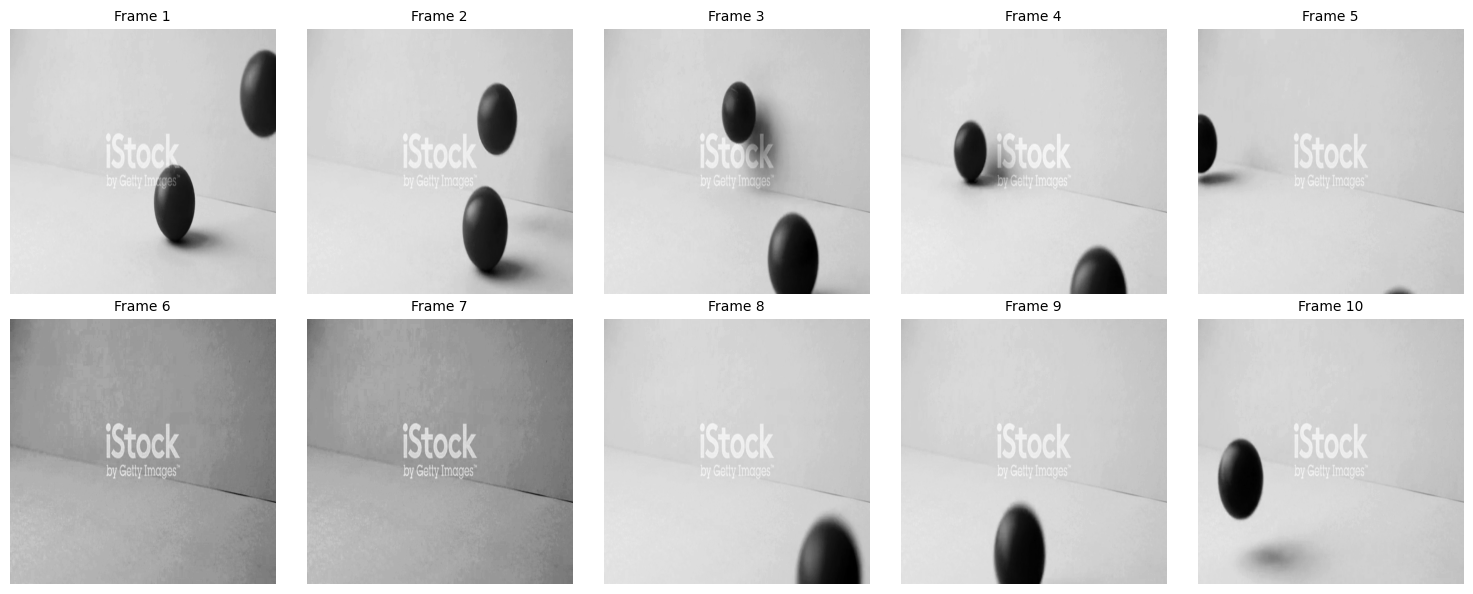

In [7]:
display_images(frames)

In [8]:
for index,frame in enumerate(frames):
    plt.imsave(f"original/frame{index}.png",frame,cmap="gray")

# Obtaining motion vectors

In [9]:
def get_motion_vectors(frames):
    motion_vectors_frames = []
    predicted_current_frames = np.empty((0, 640, 640))
    residuals = np.empty((0,640,640))

    for index,current_frame in enumerate(frames):
        if index == 0:
            continue
        #find motion vectors for the frame
        else:
            frame_motion_vectors = []
            changed = []

            for i in range(80):
                for j in range(80):
                    start_x = j*8
                    end_x = start_x + 8
                    start_y = i*8
                    end_y = start_y+8
                    previous_frame_block = frames[index-1][start_x:end_x,start_y:end_y]
                    current_frame_block = current_frame[start_x:end_x,start_y:end_y]
                    SAD = sum_of_absolute_difference(previous_frame_block,current_frame_block)
                    #check SAD
                    if SAD > 200:
                        best_match_x, best_match_y, min_sad,itter = logarithmic_search_2d(frames[index-1], current_frame_block,start_x,start_y)
                        motion_vector = best_match_x, best_match_y
                        changed.append((best_match_x, best_match_y))
                    else:
                        best_match_x, best_match_y = start_x,start_y
                        motion_vector = best_match_x, best_match_y
                    frame_motion_vectors.append(motion_vector)
            motion_vectors_frames.append(frame_motion_vectors)
    return motion_vectors_frames

In [10]:
motion_vectors_frames = get_motion_vectors(frames)

In [11]:
print(len(motion_vectors_frames))
print(motion_vectors_frames[0])

10
[(0, 0), (8, 0), (16, 0), (24, 0), (32, 0), (40, 0), (48, 0), (56, 0), (64, 0), (72, 0), (80, 0), (88, 0), (96, 0), (104, 0), (112, 0), (120, 0), (128, 0), (136, 0), (144, 0), (152, 0), (160, 0), (168, 0), (176, 0), (184, 0), (192, 0), (200, 0), (208, 0), (216, 0), (224, 0), (232, 0), (240, 0), (248, 0), (256, 0), (264, 0), (272, 0), (280, 0), (288, 0), (296, 0), (304, 0), (312, 0), (320, 0), (328, 0), (336, 0), (344, 0), (352, 0), (360, 0), (368, 0), (376, 0), (384, 0), (392, 0), (400, 0), (408, 0), (416, 0), (424, 0), (432, 0), (440, 0), (448, 0), (456, 0), (464, 0), (472, 0), (480, 0), (488, 0), (496, 0), (504, 0), (512, 0), (520, 0), (528, 0), (536, 0), (544, 0), (552, 0), (560, 0), (568, 0), (576, 0), (584, 0), (592, 0), (600, 0), (608, 0), (616, 0), (624, 0), (632, 0), (0, 8), (8, 8), (16, 8), (24, 8), (32, 8), (40, 8), (48, 8), (56, 8), (64, 8), (72, 8), (80, 8), (88, 8), (96, 8), (104, 8), (112, 8), (120, 8), (128, 8), (136, 8), (144, 8), (152, 8), (160, 8), (168, 8), (176, 

In [12]:
#these are for a single frame
def create_frame_blocks_from_motion_vectors(motion_vectors,previous_frame):
    frame_blocks = np.empty((0, 8, 8))
    
    for motion_vector in motion_vectors:
        block = previous_frame[motion_vector[0]:motion_vector[0]+8,motion_vector[1]:motion_vector[1]+8]
        frame_blocks = np.concatenate((frame_blocks, [block]), axis=0)

    return frame_blocks

def create_frame_blocks_from_motion_vectors_2(motion_vectors,previous_frame):

    frame_blocks = np.zeros((6400, 8, 8))
    itter = 0 
    
    for motion_vector in motion_vectors:
        block = previous_frame[motion_vector[0]:motion_vector[0]+8,motion_vector[1]:motion_vector[1]+8]
        frame_blocks[itter] = block
        itter = itter + 1 

    return frame_blocks

    

def create_predicted_current_frame(frame_blocks):

    predicted_current_frame = np.zeros((640,640))

    block_number = 0
    for i in range(80):
        for j in range(80):
            start_x = j*8
            end_x = start_x + 8
            start_y = i*8
            end_y = start_y+8
            predicted_current_frame[start_x:end_x,start_y:end_y] = frame_blocks[block_number]
            block_number = block_number + 1
    
    return predicted_current_frame

def create_residual(predicted_current_frame,current_frame):
    
    residual = current_frame-predicted_current_frame
    return residual

def create_compressed_residual(residual,location,level):
    compressed_residual_string = compress_complete_image(residual,level,location)
    return compressed_residual_string

# Encoder side

In [13]:
predicted_current_frames = np.empty((0,640,640))
residuals = np.empty((0,640,640))
compressed_strings = []
level = 0.5

for index,motion_vector in enumerate(motion_vectors_frames):
    frame_blocks_ = create_frame_blocks_from_motion_vectors_2(motion_vector,frames[index])
    predicted_current_frame_ = create_predicted_current_frame(frame_blocks_)
    residual_ = create_residual(predicted_current_frame_,frames[index+1])
    compressed_residual = create_compressed_residual(residual_,f"Frame_{index + 1}.txt",level)
    
    predicted_current_frames = np.concatenate((predicted_current_frames, [predicted_current_frame_]), axis=0)
    residuals = np.concatenate((residuals, [residual_]), axis=0)
    compressed_strings.append(compressed_residual)

# Obtained Predicted current frames

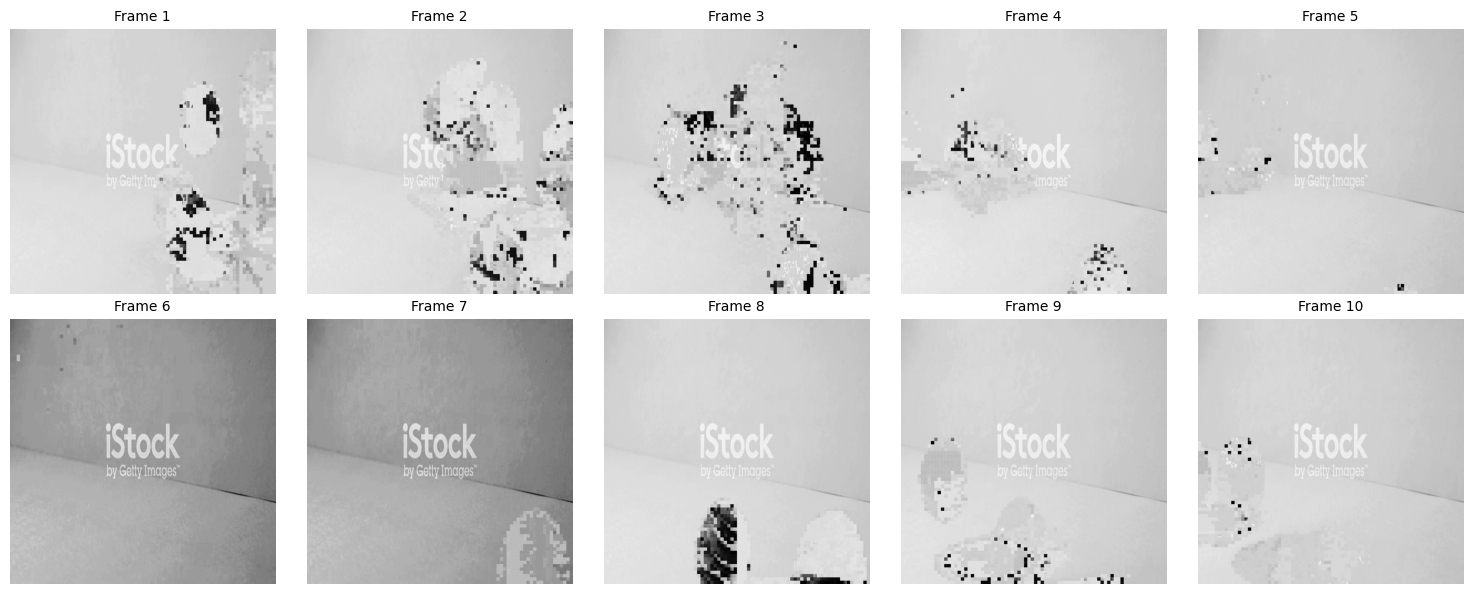

In [14]:
display_images(predicted_current_frames)

# Obtained residuals

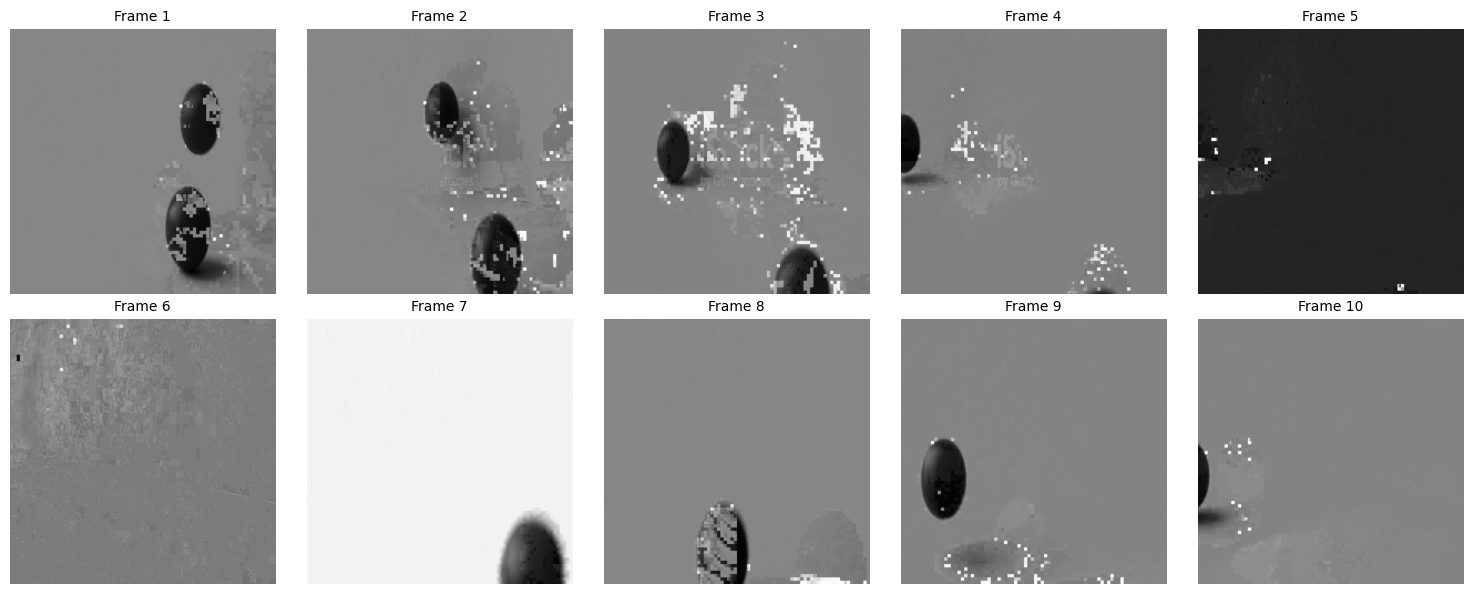

In [15]:
display_images(residuals)

# Reconstruction of frames

Obtaining decompressed residuals

In [16]:
# decompressed_residuals = np.empty((0,640,640))
decompressed_residuals = np.empty((10,640,640))
for i in range(len(compressed_strings)):
    decompressed_residual_ = decompress_complete_image(f"Frame_{i+1}.txt",level)
    # decompressed_residuals = np.concatenate((decompressed_residuals, [decompressed_residual_]), axis=0)
    decompressed_residuals[i] = decompressed_residual_

Creating predicted current frames using motion vectors (Decoder Side)

In [17]:
generated_frames = np.empty((0,640,640))
generated_frames = np.concatenate((generated_frames, [frames[0]]), axis=0)
decoder_predicted_frames = np.empty((0,640,640))

for index,motion_vector in enumerate(motion_vectors_frames):
    frame_blocks_ = create_frame_blocks_from_motion_vectors_2(motion_vector,generated_frames[index])
    predicted_current_frame_ = create_predicted_current_frame(frame_blocks_)
    generated_frame = predicted_current_frame_ + decompressed_residuals[index]

    decoder_predicted_frames = np.concatenate((decoder_predicted_frames, [predicted_current_frame_]), axis=0)
    generated_frames = np.concatenate((generated_frames, [generated_frame]), axis=0)

# Reconstructed Frames

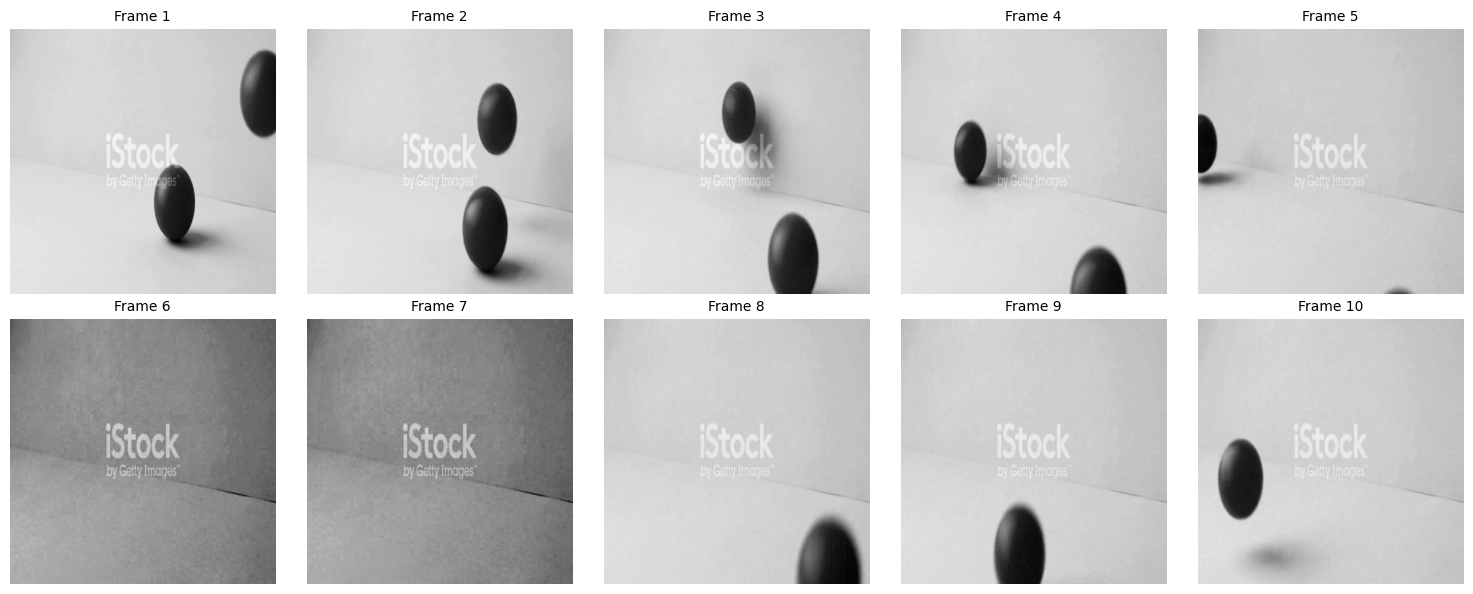

In [18]:
display_images(generated_frames)

In [19]:
for index,frame in enumerate(generated_frames):
    plt.imsave(f"video_compression_results/frame{index}.png",frame,cmap="gray")

In [20]:
for index,frame in enumerate(frames):
    plt.imsave(f"original/frame{index}.png",frame,cmap="gray")

# Adjusting compression for a fixed bit rate

Single functions were defined using all the functions defined above to compress and decompress 10 frames to help the optimization 

In [21]:
def compress_complete_video(frames,level,required_rate):
    
    motion_vectors_frames = get_motion_vectors(frames)
    predicted_current_frames = np.empty((0,640,640))
    residuals = np.empty((0,640,640))
    compressed_strings = []
    # level = 5

    for index,motion_vector in enumerate(motion_vectors_frames):
        frame_blocks_ = create_frame_blocks_from_motion_vectors_2(motion_vector,frames[index])
        predicted_current_frame_ = create_predicted_current_frame(frame_blocks_)
        residual_ = create_residual(predicted_current_frame_,frames[index+1])
        #Adjust the size here
        # compressed_residual = create_compressed_residual(residual_,f"Frame_{index + 1}.txt",level)
        print(index)
        compressed_residual = adjust_compression_of_frame(residual_,required_rate,index)
        
        predicted_current_frames = np.concatenate((predicted_current_frames, [predicted_current_frame_]), axis=0)
        residuals = np.concatenate((residuals, [residual_]), axis=0)
        compressed_strings.append(compressed_residual)

    
    
    return compressed_strings,motion_vectors_frames

def adjust_compression_of_frame(residual,required_rate,index):

    current_scaler = 0.5
    alpha = 0.05

    compressed_residual = create_compressed_residual(residual,f"Frame_{index + 1}.txt",current_scaler)
    current_rate = (len(compressed_residual)/8000)

    while True:
        print(f"Current scaler frame {index} = {current_scaler}, Current rate {current_rate}")
        if current_rate < required_rate:
            current_scaler = current_scaler - alpha
            compressed_residual = create_compressed_residual(residual,f"Frame_{index + 1}.txt",current_scaler)
            current_rate = (len(compressed_residual)/8000)
            # print(current_rate)
            if current_rate > required_rate or (current_scaler<0.4):
                break
        
        if current_rate > required_rate:
            current_scaler = current_scaler + alpha
            compressed_residual = create_compressed_residual(residual,f"Frame_{index + 1}.txt",current_scaler)
            current_rate = (len(compressed_residual)/8000)
            # print(current_rate)
            if (current_rate < required_rate) or (current_scaler<0.4):
                break
    print(f"final scaler frame {index} - {current_scaler}")
    return compressed_residual


def decompress_complete_video(compressed_strings,motion_vectors_frames,level):
    
    decompressed_residuals = np.empty((10,640,640))
    for i in range(len(compressed_strings)):
        decompressed_residual_ = decompress_complete_image(f"Frame_{i+1}.txt",level)
        # decompressed_residuals = np.concatenate((decompressed_residuals, [decompressed_residual_]), axis=0)
        decompressed_residuals[i] = decompressed_residual_
    
    generated_frames = np.empty((0,640,640))

    generated_frames = np.concatenate((generated_frames, [frames[0]]), axis=0)
    decoder_predicted_frames = np.empty((0,640,640))

    for index,motion_vector in enumerate(motion_vectors_frames):
        frame_blocks_ = create_frame_blocks_from_motion_vectors_2(motion_vector,generated_frames[index])
        predicted_current_frame_ = create_predicted_current_frame(frame_blocks_)
        generated_frame = predicted_current_frame_ + decompressed_residuals[index]

        decoder_predicted_frames = np.concatenate((decoder_predicted_frames, [predicted_current_frame_]), axis=0)
        generated_frames = np.concatenate((generated_frames, [generated_frame]), axis=0)
    
    return generated_frames


In [22]:
def compressed_video_size(compressed_strings):
    size = 0 
    for i in compressed_strings:
        size = len(i) + size
        print(len(i)/8000)
    return size

In [23]:
level = 10
compressed_strings,motion_vectors_frames = compress_complete_video(frames,level,30)

KeyboardInterrupt: 

In [ ]:
compressed_video_size_ = compressed_video_size(compressed_strings)
print(compressed_video_size_/8000)

In [ ]:
generated_frames = decompress_complete_video(compressed_strings,motion_vectors_frames,level)

# Obtained frames after adjusting for a certain bit rate

In [ ]:
display_images(generated_frames)